In [18]:
import numpy as np
from environments.data_separator import dataSrlLoad, plotDistribution
import torch as th
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
BATCH_SIZE = 256
N_WORKERS = 8
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")
VALIDATION_SIZE = 0.2  # 20% of training data for validation

In [3]:
srl_model_path = 'srl_zoo/logs/Omnibot_random_simple//19-06-17_15h37_05_custom_cnn_ST_DIM200_inverse_autoencoder/srl_model.pth'
data_folder = '/home/tete/Robotics-branches/escape-dev/robotics-rl-srl/data/random_reaching_on_policy/'

In [4]:
pca_srl_data, training, validation = dataSrlLoad(data_folder, srl_model_path, pca_mode=True, normalized=True)


SRL: Using custom_cnn with inverse, autoencoder 

Loading trained model...srl_zoo/logs/Omnibot_random_simple//19-06-17_15h37_05_custom_cnn_ST_DIM200_inverse_autoencoder/srl_model.pth
Loading data for separation 


100%|██████████| 74/74 [00:21<00:00,  3.49it/s]

In [5]:
num_sample = len(pca_srl_data)
num_val = int(num_sample * VALIDATION_SIZE)

In [6]:
def plotDistribution(pca_srl_data, val_num):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[24, 8])
    x_min, x_max = pca_srl_data[:, 0].min(), pca_srl_data[:, 0].max()
    y_min, y_max = pca_srl_data[:, 1].min(), pca_srl_data[:, 1].max()
    ax[0].scatter(pca_srl_data[val_num:, 0], pca_srl_data[val_num:, 1], s=5, c='b', label='Training')
    ax[0].scatter(pca_srl_data[:val_num, 0], pca_srl_data[:val_num, 1], s=5, c='r', label='Validation')
    ax[0].legend()
    ax[0].title.set_text('Sample')
    # plt.show()
    ax[1].hist2d(pca_srl_data[:val_num, 0], pca_srl_data[:val_num, 1],
                 bins=100, range=[[x_min, x_max], [y_min, y_max]])
    ax[1].title.set_text('Validation distribution')
    ax[2].hist2d(pca_srl_data[val_num:, 0], pca_srl_data[val_num:, 1],
                 bins=100, range=[[x_min, x_max], [y_min, y_max]])
    ax[2].title.set_text('Training distribution')

    plt.show()

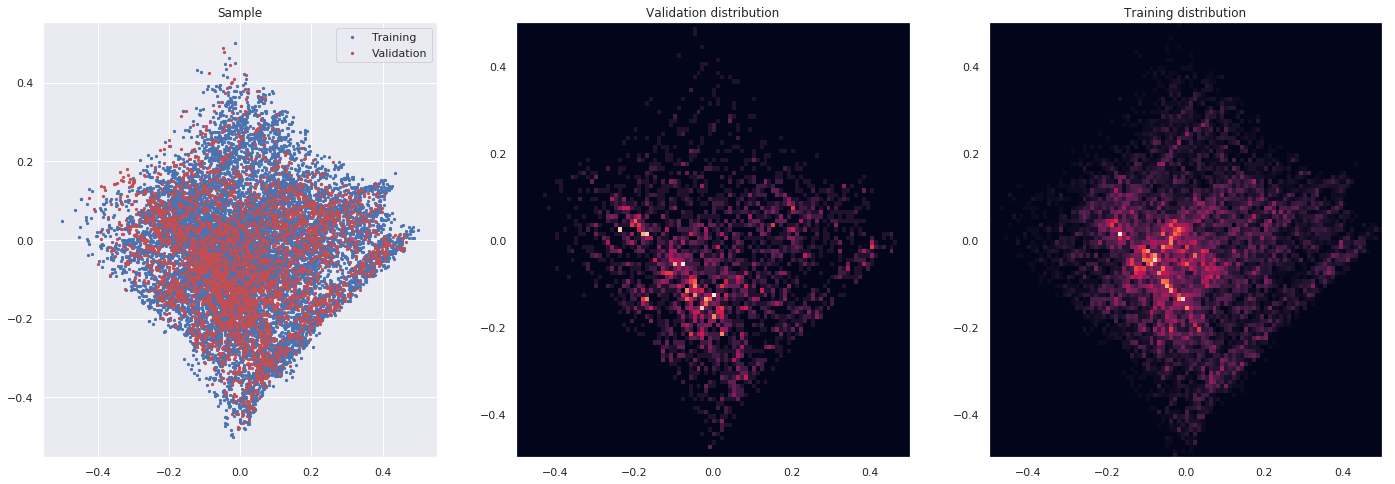

In [7]:
plotDistribution(pca_srl_data, num_val)

In [8]:
pca_srl_data

array([[ 0.04232138, -0.29665422],
       [-0.00479653, -0.24115586],
       [-0.03012252, -0.21624807],
       ...,
       [ 0.14181286, -0.289236  ],
       [ 0.14182305, -0.28917688],
       [ 0.1130774 , -0.2586394 ]], dtype=float32)

In [9]:
ang = np.pi/4
rot_mat = np.array([[np.cos(ang), -np.sin(ang)],
                    [np.sin(ang), np.cos(ang)]])

In [10]:
rotated_data = np.matmul(pca_srl_data, rot_mat)

In [11]:
rotated_data

array([[-0.17984048, -0.23969195],
       [-0.17391461, -0.16713128],
       [-0.17421031, -0.13161064],
       ...,
       [-0.10424391, -0.30479758],
       [-0.10419489, -0.30476298],
       [-0.10292787, -0.26284347]])

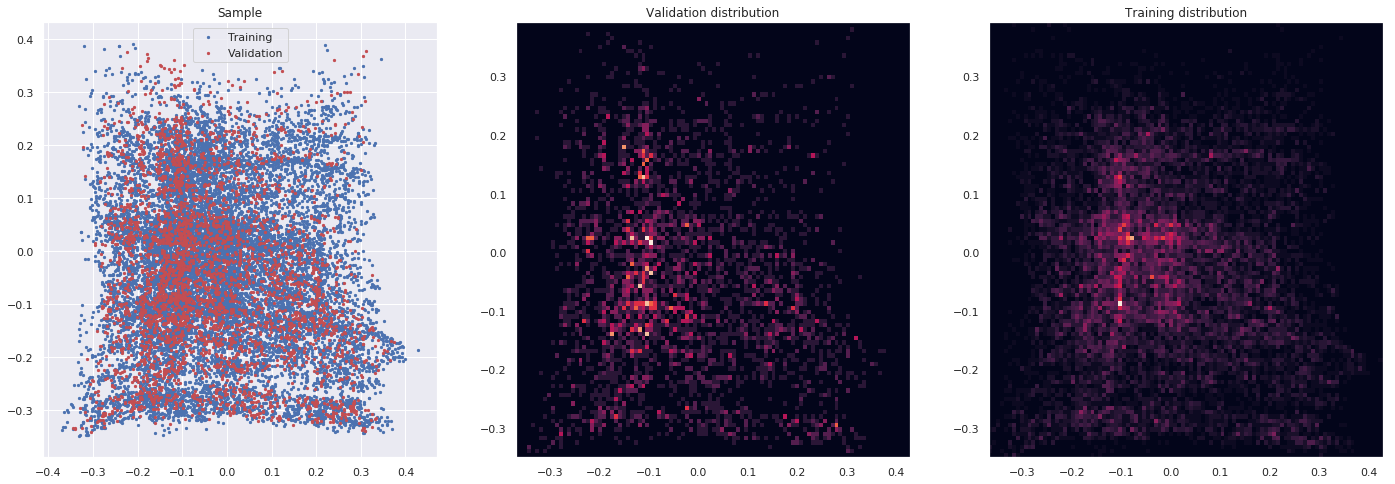

In [12]:
plotDistribution(rotated_data, num_val)

In [13]:
train_set, val_set = pca_srl_data[num_val:], pca_srl_data[:num_val]

In [14]:
train_set.shape

(15156, 2)

In [121]:
from multiprocessing import Pool

def del_val(p_val):
    for p_train in train_set:
        if(np.linalg.norm(p_val-p_train) > 100):
            return 1
        else:
            return 0
pool = Pool()                         # Create a multiprocessing Pool
%time index = pool.map(del_val, val_set) 

CPU times: user 254 ms, sys: 638 ms, total: 892 ms
Wall time: 23.2 s


In [123]:
index.index(None)

0

In [114]:
from functools import partial
def _del_val(p_val):
    for p_train in train_set:
        if(1.e-10<np.linalg.norm(p_val-p_train) < threshold):
            # we will delete the data point
            return True
    return False
        
def dataSelection(threshold, train_set, val_set=None):
    """

    :param val_set: the validation set that we want to resimpling
    :param train_set:
    :param threshold:
    :return:
    """

    if val_set == None:
        val_set = train_set

    pool = Pool()
    index = pool.map(partial(_del_val, train_set=train_set, threshold=threshold), train_set)
    #index = _del_val(val_set[0])
    return index

In [115]:
threshold = 0.001
train_set = train_set
pool = Pool()
%time index_del = pool.map(_del_val, train_set)

CPU times: user 1.13 s, sys: 3.58 s, total: 4.71 s
Wall time: 1min 45s


In [116]:
index_save = [i for i in range(len(index_del)) if not index_del[i]]

In [120]:
index_save.__len__()


12382

In [117]:
train_set[index_save].__len__()

12382

In [118]:
train_set.shape, len(index_del)

((15156, 2), 15156)

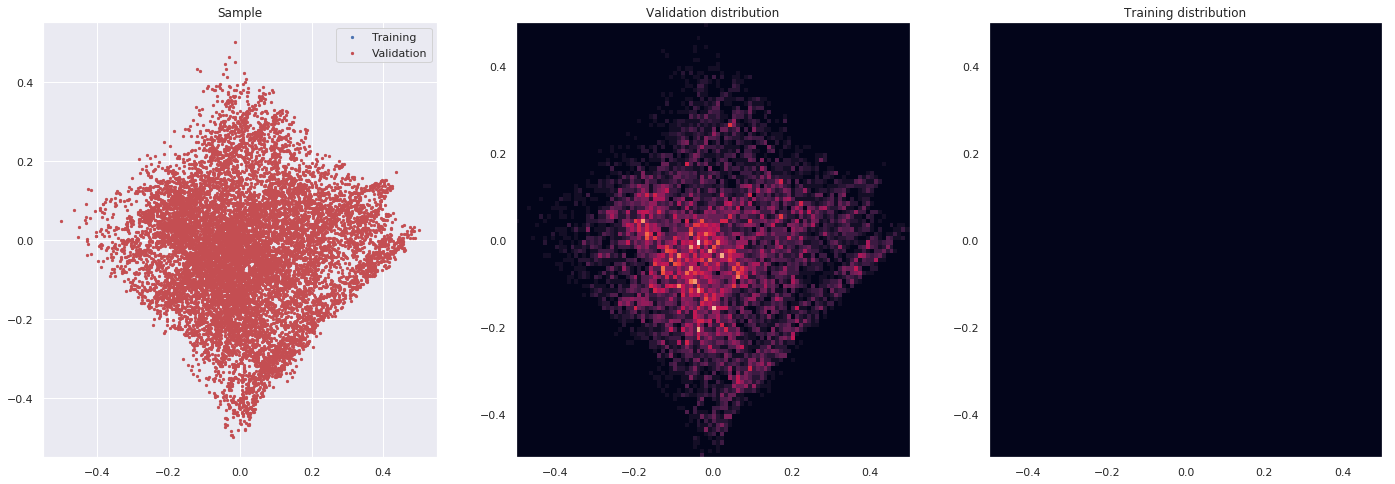

In [121]:
plotDistribution(train_set[index_save], 10000000)

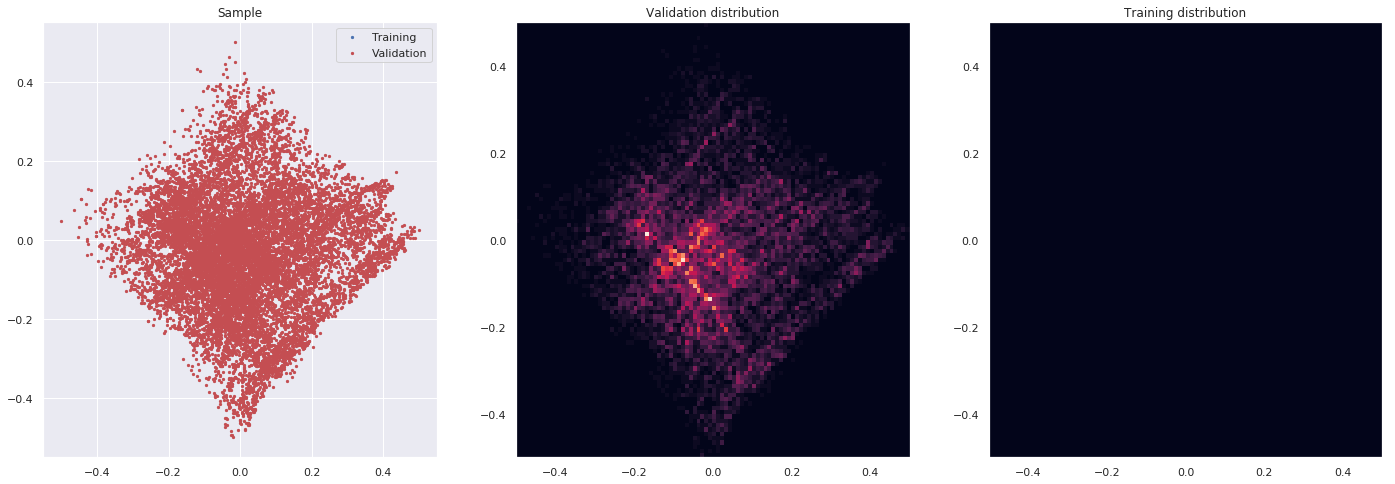

In [122]:
plotDistribution(train_set, 10000000)